In [8]:
#1> load the environment + define the path
%reload_ext autoreload
%autoreload 2

#make data file
print( "Takes <30s. However, it might take >1 mins or so if network is busy...")
import glob
import os
import pandas as pd
from datetime import datetime
import numpy as np
import main_funcs as mfun
import utils_funcs as utils # utils is from Vape - catcher file: 
import matplotlib.pyplot as plt
import pickle



# Get the list of recordings
info = mfun.analysis()
# display the detected session
print( "Total Session: " +  str(info.recordingList .shape[0]))
#info.recordingList.head()

# set matlab API
import matlab.engine
eng = matlab.engine.start_matlab()
print('Matlab engine is set correctly.')

info.recordingList

Takes <30s. However, it might take >1 mins or so if network is busy...
Computer: Candela Windows


c:\Users\Lak Lab\Documents\Github\sideBiasLateralisation\main_funcs.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation\analysis\2025-01-24_MBL015_1\' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.recordingList.recordingID[ind])


Total Session: 217
Matlab engine is set correctly.


,animalID,recordingDate,recordingID,sessionName,learningData,twoP,path,sessionNameWithPath,blockName,imagingTiffFileNames,analysispathname,filepathname
0,MBL015,2025-01-24,1,2025-01-24_1_MBL015,False,False,Z:/MBL015\2025-01-24,Z:/MBL015\2025-01-24\1\2025-01-24_1_MBL015_Blo...,2025-01-24_1_MBL015,,C:/Users/Lak Lab/Documents/Github/sideBiasLate...,Z:/MBL015\2025-01-24\1
1,MBL015,2025-01-27,1,2025-01-27_1_MBL015,False,False,Z:/MBL015\2025-01-27,Z:/MBL015\2025-01-27\1\2025-01-27_1_MBL015_Blo...,2025-01-27_1_MBL015,,C:/Users/Lak Lab/Documents/Github/sideBiasLate...,Z:/MBL015\2025-01-27\1
2,MBL015,2025-01-28,1,2025-01-28_1_MBL015,False,False,Z:/MBL015\2025-01-28,Z:/MBL015\2025-01-28\1\2025-01-28_1_MBL015_Blo...,2025-01-28_1_MBL015,,C:/Users/Lak Lab/Documents/Github/sideBiasLate...,Z:/MBL015\2025-01-28\1
3,MBL015,2025-01-29,1,2025-01-29_1_MBL015,False,False,Z:/MBL015\2025-01-29,Z:/MBL015\2025-01-29\1\2025-01-29_1_MBL015_Blo...,2025-01-29_1_MBL015,,C:/Users/Lak Lab/Documents/Github/sideBiasLate...,Z:/MBL015\2025-01-29\1
4,MBL015,2025-01-30,1,2025-01-30_1_MBL015,False,False,Z:/MBL015\2025-01-30,Z:/MBL015\2025-01-30\1\2025-01-30_1_MBL015_Blo...,2025-01-30_1_MBL015,,C:/Users/Lak Lab/Documents/Github/sideBiasLate...,Z:/MBL015\2025-01-30\1
...,...,...,...,...,...,...,...,...,...,...,...,...
212,MBL014,2025-06-18,1,2025-06-18_1_MBL014,False,True,Z:/MBL014\2025-06-18,Z:/MBL014\2025-06-18\1\2025-06-18_1_MBL014_Blo...,2025-06-18_1_MBL014,Z:/MBL014\2025-06-18\TwoP\2025-06-18_t-001,C:/Users/Lak Lab/Documents/Github/sideBiasLate...,Z:/MBL014\2025-06-18\1
213,MBL014,2025-06-19,1,2025-06-19_1_MBL014,False,True,Z:/MBL014\2025-06-19,Z:/MBL014\2025-06-19\1\2025-06-19_1_MBL014_Blo...,2025-06-19_1_MBL014,Z:/MBL014\2025-06-19\TwoP\2025-06-19_t-001,C:/Users/Lak Lab/Documents/Github/sideBiasLate...,Z:/MBL014\2025-06-19\1
214,MBL014,2025-06-20,1,2025-06-20_1_MBL014,False,True,Z:/MBL014\2025-06-20,Z:/MBL014\2025-06-20\1\2025-06-20_1_MBL014_Blo...,2025-06-20_1_MBL014,Z:/MBL014\2025-06-20\TwoP\2025-06-20_t-001,C:/Users/Lak Lab/Documents/Github/sideBiasLate...,Z:/MBL014\2025-06-20\1
215,MBL014,2025-06-21,1,2025-06-21_1_MBL014,False,False,Z:/MBL014\2025-06-21,Z:/MBL014\2025-06-21\1\2025-06-21_1_MBL014_Blo...,2025-06-21_1_MBL014,,C:/Users/Lak Lab/Documents/Github/sideBiasLate...,Z:/MBL014\2025-06-21\1


In [10]:
# List of sessions to filter
#specific_expRefs = ['2025-05-16_1_MBL015', '2025-05-20_1_MBL015', '2025-05-22_1_MBL015', '2025-05-14_1_MBL015']
specific_expRefs = ['2025-05-20_1_MBL015', '2025-05-22_1_MBL015']
#specific_expRefs = ['2025-06-13_3_MBL014']
# Filter the recording list to include only the specified sessions
info.recordingList = info.recordingList[info.recordingList['sessionName'].isin(specific_expRefs)].reset_index(drop=True)
info.recordingList

,animalID,recordingDate,recordingID,sessionName,learningData,twoP,path,sessionNameWithPath,blockName,imagingTiffFileNames,analysispathname,filepathname
0,MBL015,2025-05-20,1,2025-05-20_1_MBL015,False,True,Z:/MBL015\2025-05-20,Z:/MBL015\2025-05-20\1\2025-05-20_1_MBL015_Blo...,2025-05-20_1_MBL015,Z:/MBL015\2025-05-20\TwoP\2025-05-20_t-001,C:/Users/Lak Lab/Documents/Github/sideBiasLate...,Z:/MBL015\2025-05-20\1
1,MBL015,2025-05-22,1,2025-05-22_1_MBL015,False,True,Z:/MBL015\2025-05-22,Z:/MBL015\2025-05-22\1\2025-05-22_1_MBL015_Blo...,2025-05-22_1_MBL015,Z:/MBL015\2025-05-22\TwoP\2025-05-22_t-001,C:/Users/Lak Lab/Documents/Github/sideBiasLate...,Z:/MBL015\2025-05-22\1


In [6]:
#2>  create + save beh fig

for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    session = str(info.recordingList.sessionName[ind])  # Usar ind en lugar de 0
    save_path = info.recordingList.analysispathname[ind]  # Usar ind en lugar de 0
    save_file = os.path.join(save_path, f"{session}_behavior_plot.png")

    # Check if file already exists
    if os.path.exists(save_file):
        print(f"File already exists for session {session}, skipping visualization")
        print(f"Existing file: {save_file}")
    else:
        try:
            # Create figure and get handle
            eng.visualiseTrainingGrating2AFC(session, 'Grating2AFC_noTimeline', [], nargout=0)
            
            # Get the current figure handle
            fig = eng.gcf()
            
            # Save the figure
            eng.saveas(fig, save_file, nargout=0)
            #eng.close(fig, nargout=0)  # Close the figure
            
            print(f"Visualization completed and saved for session {session}")
            print(f"Saved to: {save_file}")
        except Exception as e:
            print(f"Error when running visualiseTrainingGrating2AFC: {str(e)}")

Visualization completed and saved for session 2025-06-13_3_MBL014
Saved to: C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation\analysis\2025-06-13_MBL014_3\2025-06-13_3_MBL014_behavior_plot.png


In [10]:
#3> Extract PAQ data and create imaging frames file
import sys
import glob
sys.path.append('LakLabAnalysis/Utility')  # Asegurarse que el path está en el sistema
from extract_paq_events import extract_paq_data_frame

# For every session in  recordingList
for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    # Build the path to the PAQ file using glob to find any .paq file
    paq_path = os.path.join(info.recordingList.path[ind], 'TwoP', '*.paq')
    paq_files = glob.glob(paq_path)
    
    if paq_files:
        print(f"Processing paq and creating imaging_frames.txt for session: {info.recordingList.sessionName[ind]}")
        for paq_file in paq_files:
            try:
                # Extract data and create imaging_frames.txt
                extract_paq_data_frame(paq_file)
                print(f"imaging_frames.txt created successfully for {os.path.basename(paq_file)}")
            except Exception as e:
                print(f"Error processing {os.path.basename(paq_file)}: {str(e)}")
    else:
        print(f"No paq files found for session: {info.recordingList.sessionName[ind]}")

Processing paq and creating imaging_frames.txt for session: 2025-05-22_1_MBL015
Saved file: Z:/MBL015\2025-05-22\TwoP\2025-05-22_MBL015_1_paq_imaging_frames.txt
Saved file: Z:/MBL015\2025-05-22\TwoP\2025-05-22_MBL015_1_paq_reward_frames.txt
imaging_frames.txt created successfully for 2025-05-22_MBL015_1_paq.paq


In [18]:
#4> Check CSV files 
# checkOnly needs to be False to create new files with MATLAB GENERIC CODE: GetBehavData.mat
checkOnly = False # Make false when there is more behaviour session
alignSubtract = True

for ind, recordingDate in enumerate(info.recordingList.recordingDate):

    filenameCSV = info.recordingList.analysispathname[ind] + info.recordingList.sessionName[ind] + '_CorrectedeventTimes.csv'
    e_filenameCSV = [f for f in glob.glob(filenameCSV)]
    if len(e_filenameCSV)==1:
        info.recordingList.loc[ind,'eventTimesExtracted']=1
        info.recordingList.loc[ind,'eventTimesPath'] = filenameCSV
    else:
        if checkOnly:
            info.recordingList.loc[ind,'eventTimesExtracted']=0
            info.recordingList.loc[ind,'eventTimesPath'] = filenameCSV
        else:
            try:
                filenameTimeline = [f for f in glob.glob(info.recordingList.filepathname[ind]+ '\\' + info.recordingList.sessionName[ind] + '_Timeline.mat')]
                if  (len(filenameTimeline)>0):
                    sessionProfile ='Grating2AFC'
                else:
                    sessionProfile ='Grating2AFC_noTimeline'
                
                # Get behaviour trial data from Block.mat file
                print(' Extracting time events--> Profile: ' + sessionProfile  +'  Session: ' + info.recordingList.sessionName[ind])
                data = eng.getBehavData(info.recordingList.sessionName[ind],sessionProfile)

                # Apply correction based on the weights to match the eventTimes
                if (alignSubtract) & (len(filenameTimeline)>0) & (info.recordingList.twoP[ind]==True): 
                    print(' Aligning time events: ' + info.recordingList.sessionName[ind])
                    # Get weights to convert from probe to behavioural timebase
                    twoPpath = info.recordingList.path[ind] + '\\TwoP'
                    sessionName = info.recordingList.sessionName[ind]
                    figsavepath = info.recordingList.analysispathname[ind]
                    dataCorrected, variance = eng.applySubtractionCorrection (data, twoPpath ,sessionName, True, figsavepath, nargout=2)
                    info.recordingList.loc[ind,'variance'] = variance

                    # Apply correction to the signal
                    data = dataCorrected
                    
                # Save the file
                eng.writetable(data, filenameCSV, nargout=0)
                info.recordingList.loc[ind,'eventTimesExtracted']=1
            except:
                print(str(ind) + ' - FAILED: Extracting time events: ' + info.recordingList.sessionName[ind])
                info.recordingList.loc[ind,'eventTimesExtracted']=0

# display the output
print( "Behaviour trial data extraction completed: " + 
      str(info.recordingList.eventTimesExtracted.sum()) +"/" + str(info.recordingList.shape[0]))

 Extracting time events--> Profile: Grating2AFC  Session: 2025-05-20_1_MBL015
 Aligning time events: 2025-05-20_1_MBL015
 Extracting time events--> Profile: Grating2AFC  Session: 2025-05-22_1_MBL015
 Aligning time events: 2025-05-22_1_MBL015
Behaviour trial data extraction completed: 2.0/2


In [2]:
#5a> SANDRA'S settings for suite2p
# for GCaMP6s
#diameter_um = 7.9
ops = {
        'batch_size': 200, # reduce if running out of RAM        
        'fast_disk': 'D:\\suite2p_binaries',
        'delete_bin': False, # whether to delete binary file after processing
        'move_bin': True, # moves temp data.bin from fast_disk to save_path if save_path!=fast_disk
        'diameter': 14, # this is the main parameter for cell detection, 2-dimensional if Y and X are different (e.g. [6 12])
        # main settings
        'nplanes' : 1, # each tiff has these many planes in sequence
        'nchannels' : 1, # each tiff has these many channels per plane
        'functional_chan' : 1, # this channel is used to extract functional ROIs (1-based)
        'tau':  1.25, # this is the main parameter for deconvolution (1.25-1.5 for gcamp6s)
        'fs': 30, # sampling rate (total across planes, will auto-change from .csv)
        # output settings
        'save_mat': True, # whether to save output as matlab files
        'combined': True, # combine multiple planes into a single result /single canvas for GUI
        'save_NWB': 0.0,
        'aspect': 1.0,
        'do_bidiphase': False,
        'bidiphase': 0,
        'bidi_corrected': True,

        # registration settings
        'do_registration': True, # whether to register data
        'two_step_registration': 0.0,
        'keep_movie_raw': False,
        'nimg_init': 500, # subsampled frames for finding reference image
        'batch_size': 500,
        'maxregshift': 0.1, # max allowed registration shift, as a fraction of frame max(width and height)
        'align_by_chan' : 1, # when multi-channel, you can align by non-functional channel (1-based)
        'reg_tif': False, # whether to save registered tiffs
        'subpixel' : 10, # precision of subpixel registration (1/subpixel steps)
        'smooth_sigma_time': 0.0,
        'smooth_sigma': 1.15,
        'th_badframes': 1.0,
        'norm_frames': True,
        'force_refImg': False,
        'pad_fft': False,

        #Non-rigid
        'nonrigid': True,
        'block_size': [128, 128],
        'snr_thresh': 1.2,
        'maxregshiftNR': 5.0,

        #1P
        '1Preg': False,
        'spatial_hp_reg': 42.0,
        'pre_smooth': 0.0,
        'spatial_taper': 40.0,
        
        # Functional cell detection settings
        'roidetect': True,
        'spikedetect': True,
        'sparse_mode': True,
        'spatial_scale': 0,
        'connected': True, # whether or not to keep ROIs fully connected (set to 0 for dendrites)
        # 'navg_frames_svd': 5000, # max number of binned frames for the SVD
        # 'nsvd_for_roi': 1000, # max number of SVD components to keep for ROI detection
        'max_iterations': 30, # maximum number of iterations to do cell detection
        # 'ratio_neuropil': 6., # ratio between neuropil basis size and cell radius
        # 'ratio_neuropil_to_cell': 3, # minimum ratio between neuropil radius and cell radius
        # 'tile_factor': 1., # use finer (>1) or coarser (<1) tiles for neuropil estimation during cell detection
        'threshold_scaling': 0, # adjust the automatically determined threshold by this scalar multiplier
        'max_overlap': 0.75, # cells with more overlap than this get removed during triage, before refinement
        'high_pass': 100.0,
        'spatial_hp_detect': 25.0,
        'denoise': 0.0,
        
        #Anatomical detection
        'anatomical_only': 3,
        #'diameter': [10], #14, #in pixels; be the equivalent of 8 um ? 15 um? 
        'cellprob_threshold': -6.0,
        'flow_threshold': 0.0,
        'spatial_hp_cp': 0.0,
        'pretrained_model': 'cyto',
        
        # Extraction/Neuropil & Classify/Deconvolute
        'soma_crop': 1.0,
        'neuropil_extract': True,
        'inner_neuropil_radius': 2,
        'min_neuropil_pixels': 350,
        # 'lam_percentile': 50.0,  #not listed in ops settings dialog
        'allow_overlap': True,
        'use_builtin_classifier': False,
        'classifier_path': '',
        # 'chan2_thres': 0.65, #not listed in ops settings dialog
        # 'baseline': 'maximin',  #not listed in ops settings dialog
        'win_baseline': 60.0,
        'sig_baseline': 10.0,
        # 'prctile_baseline': 8.0, #not listed in ops settings dialog
        'neucoeff': 0.7,
      }
ops_mCh = {
        #Anatomical detection
        'anatomical_only': 4, ##MAX PROJECTION
        'diameter': 15, ##STRICTER TO REALLY JUST GET WHOLE CELLS
        'cellprob_threshold': -6.0,
        'flow_threshold': 1.5, #STRICTER
        'spatial_hp_cp': 0.0,
        'pretrained_model': 'cyto',
      }

ops_CTb = {
        #Anatomical detection
        'anatomical_only': 2, ##Mean PROJECTION
        'diameter': 15, ##STRICTER TO REALLY JUST GET WHOLE CELLS
        'cellprob_threshold': -6.0,
        'flow_threshold': 0, #less strict
        'spatial_hp_cp': 0.0,
        'pretrained_model': 'cyto',
      }

#imagingParams_path = os.path.join(info.recordingListPath, "helperfiles", "2025-01_ImagingLogs_SAT017_AMRev.csv").replace('\\', '/')
#imagingParams = pd.read_csv(imagingParams_path)
#sessionDates = [session[:10] for session in imagingParams['session']]
errorLog = []
remake = False

In [ ]:
#5a> default settings for Suite2p analysis
ops = {
        'batch_size': 500, # reduce if running out of RAM
        'fast_disk': 'D:\\suite2p_binaries', # used to store temporary binary file, defaults to save_path0 (set as a string NOT a list)
        #'fast_disk': os.path.expanduser('~/suite2p_binaries'), # used to store temporary binary file, defaults to save_path0 (set as a string NOT a list)
         #'save_path0': '/media/jamesrowland/DATA/plab/suite_2p', # stores results, defaults to first item in data_path
        'delete_bin': False, # whether to delete binary file after processing
        # main settings
        'nplanes' : 1, # each tiff has these many planes in sequence
        'nchannels' : 1, # each tiff has these many channels per plane
        'functional_chan' : 1, # this channel is used to extract functional ROIs (1-based)
        'diameter': 16, # this is the main parameter for cell detection, 2-dimensional if Y and X are different (e.g. [6 12])
        'tau':  1.25, # this is the main parameter for deconvolution (1.25-1.5 for gcamp6s)
        'fs': 30.,  # sampling rate (total across planes)
        # output settings
        'save_mat': True, # whether to save output as matlab files
        'combined': True, # combine multiple planes into a single result /single canvas for GUI
        # parallel settings
        'num_workers': 0, # 0 to select num_cores, -1 to disable parallelism, N to enforce value
        'num_workers_roi': 0, # 0 to select number of planes, -1 to disable parallelism, N to enforce value
        # registration settings
        'do_registration': True, # whether to register data
        'nimg_init': 500, # subsampled frames for finding reference image
        'maxregshift': 0.1, # max allowed registration shift, as a fraction of frame max(width and height)
        'align_by_chan' : 1, # when multi-channel, you can align by non-functional channel (1-based)
        'reg_tif': True, # whether to save registered tiffs
        'subpixel' : 10, # precision of subpixel registration (1/subpixel steps)
        # cell detection settings
        'connected': True, # whether or not to keep ROIs fully connected (set to 0 for dendrites)
        #'navg_frames_svd': 5000, # max number of binned frames for the SVD
        #'nsvd_for_roi': 1000, # max number of SVD components to keep for ROI detection
        'max_iterations': 30, # maximum number of iterations to do cell detection
        #'ratio_neuropil': 6., # ratio between neuropil basis size and cell radius
        #'ratio_neuropil_to_cell': 3, # minimum ratio between neuropil radius and cell radius
        #'tile_factor': 1., # use finer (>1) or coarser (<1) tiles for neuropil estimation during cell detection
        'threshold_scaling': 0., # adjust the automatically determined threshold by this scalar multiplier
        'max_overlap': 0.75, # cells with more overlap than this get removed during triage, before refinement
        'inner_neuropil_radius': 2, # number of pixels to keep between ROI and neuropil donut
        'outer_neuropil_radius': np.inf, # maximum neuropil radius
        'min_neuropil_pixels': 350, # minimum number of pixels in the neuropil
        # deconvolution settings
        #'baseline': 'maximin', # baselining mode
        'win_baseline': 60., # window for maximin
        'sig_baseline': 10., # smoothing constant for gaussian filter
        #'prctile_baseline': 8.,# optional (whether to use a percentile baseline)
        'neucoeff': .7,  # neuropil coefficient
      }


In [ ]:
#5b> Run Suite2p

for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    # Check if twoP is True
    if info.recordingList.twoP[ind]:
        tiff_directory = os.path.join(info.recordingList.path[ind], 'TwoP', f"{info.recordingList.recordingDate[ind]}_t-001")
        suite2p_folder = os.path.join(tiff_directory, 'suite2p')
        e_suite2p_folder = [f for f in glob.glob(suite2p_folder)]
        if len(e_suite2p_folder)==1:
                info.recordingList.loc[ind,'suite2pPath'] = suite2p_folder
                print(f"{info.recordingList.animalID[ind]}{info.recordingList.recordingDate[ind]}: Suite2p is created before")
        else:
            db = { 
                        'data_path':  os.path.join(info.rawPath, info.recordingList.animalID[ind]),
                        'tiff_list': glob.glob(os.path.join(tiff_directory, "*.tif")),
                        'save_folder': suite2p_folder
                        }
            from suite2p.run_s2p import run_s2p
            import time        
            t1 = time.time()
            opsEnd = run_s2p(ops=ops,db=db)
            t2 = time.time()
            print(f"{info.recordingList.animalID[ind]}: Suite2p is created in {t2 - t1} seconds.")
    else:
        print(f"Skipping Suite2p for {info.recordingList.animalID[ind]} - twoP is False")
    
print('Completed')

In [9]:
#6> extract suite2p output

for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    # Define the output file path
    filenameINFO = os.path.join(info.recordingList.analysispathname[ind], 'imaging-data.pkl')
    
    # Check if file already exists
    if os.path.exists(filenameINFO):
        print(f"File already exists for session {info.recordingList.sessionName[ind]}, skipping extraction")
        print(f"Existing file: {filenameINFO}")
    else:
        try:
            # Read suite2p
            s2p_path = os.path.join(info.recordingList.path[ind], 'TwoP', f"{info.recordingList.recordingDate[ind]}_t-001", 'suite2p', 'plane0')
            if os.path.exists(s2p_path):
                print('Extracting...')
                ops = np.load(os.path.join(s2p_path, 'ops.npy'), allow_pickle=True)
                ops = ops.item()
                FrameNums = ops['frames_per_file']
                filelist = ops['filelist']
                isCell = np.load(os.path.join(s2p_path, 'iscell.npy'), allow_pickle=True)

                # Load the suite2p
                flu_raw_subtracted, spks, stat = utils.s2p_loader(s2p_path)
                flu = utils.dfof2(flu_raw_subtracted)

                # Cut each session & save it in the analysis-session folder
                imaging_data = {
                    "n_frames": FrameNums,
                    "flu": flu,
                    "spks": spks,
                    "stat": stat,
                }
                
                print(f"{filenameINFO} --> # of cells: {flu.shape[0]} # of frames: {flu.shape[1]}")
                with open(filenameINFO, 'wb') as f:
                    pickle.dump(imaging_data, f)
                print(f"Successfully saved imaging data for session {info.recordingList.sessionName[ind]}")
            else:
                print(f"Suite2p path not found: {s2p_path}")
        except Exception as e:
            print(f"Error processing session {info.recordingList.sessionName[ind]}: {str(e)}")

        

Extracting...
loading 46 traces labelled as cells
subtracting neuropil with a coefficient of 0.7
C:/Users/Lak Lab/Documents/Github/sideBiasLateralisation\analysis\2025-06-13_MBL014_3\imaging-data.pkl --> # of cells: 46 # of frames: 54113
Successfully saved imaging data for session 2025-06-13_3_MBL014


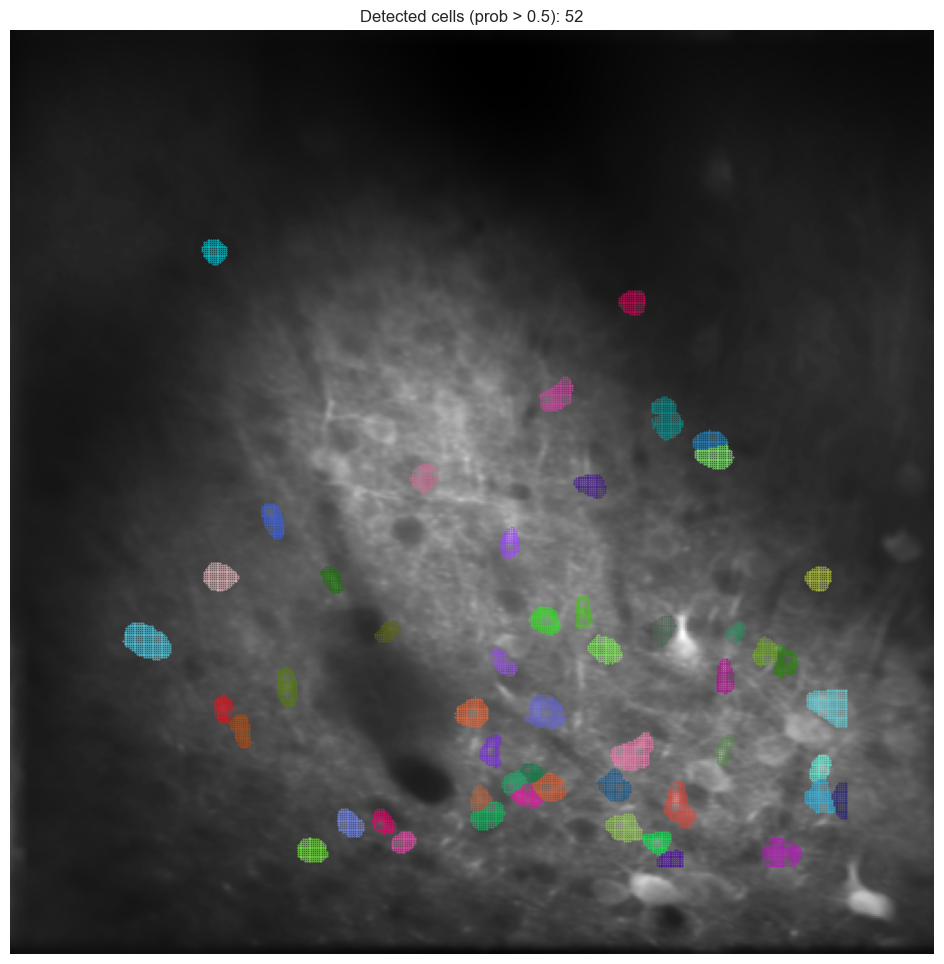

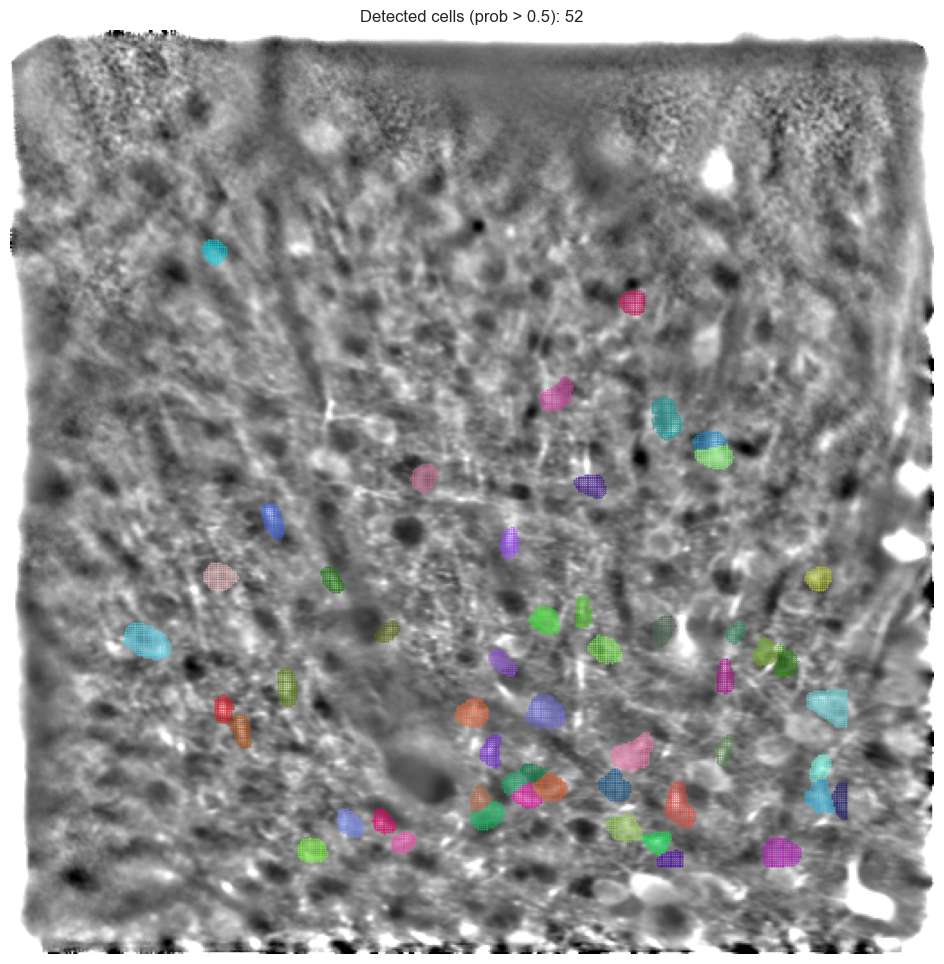

In [8]:
#7> Visualize cells
# Filter cells with probability > 0.5
prob_threshold = 0.5
cell_indices = np.where((isCell[:,0] == 1) & (isCell[:,1] > prob_threshold))[0]

# Create figure
fig, ax = plt.subplots(figsize=(12, 12))

# Show mean image
ax.imshow(ops['meanImg'], cmap='binary_r')

# Load stat.npy to get cell coordinates
stat = np.load(os.path.join(s2p_path, 'stat.npy'), allow_pickle=True)

# Generate random colors for each cell
colors = np.random.rand(len(cell_indices), 3)

# Draw ROIs of filtered cells
for idx, cell_number in enumerate(cell_indices):
    stat_cell = stat[cell_number]
    ypix = [stat_cell['ypix'][i] for i in range(len(stat_cell['ypix'])) if not stat_cell['overlap'][i]]
    xpix = [stat_cell['xpix'][i] for i in range(len(stat_cell['xpix'])) if not stat_cell['overlap'][i]]
    ax.plot(xpix, ypix, '.', markersize=1, alpha=0.7, color=colors[idx])

ax.set_title(f"Detected cells (prob > {prob_threshold}): {len(cell_indices)}")
ax.axis('off')
plt.show()

# Also show enhanced image (meanImgE) which might be clearer
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(ops['meanImgE'], cmap='binary_r')

# Draw ROIs of filtered cells
for idx, cell_number in enumerate(cell_indices):
    stat_cell = stat[cell_number]
    ypix = [stat_cell['ypix'][i] for i in range(len(stat_cell['ypix'])) if not stat_cell['overlap'][i]]
    xpix = [stat_cell['xpix'][i] for i in range(len(stat_cell['xpix'])) if not stat_cell['overlap'][i]]
    ax.plot(xpix, ypix, '.', markersize=1, alpha=0.7, color=colors[idx])

ax.set_title(f"Detected cells (prob > {prob_threshold}): {len(cell_indices)}")
ax.axis('off')
plt.show()

In [6]:
#8> Check Suite2p extraction

for ind, recordingDate in enumerate(info.recordingList.recordingDate):
    filenameDFF = info.recordingList.analysispathname[ind] + 'imaging-data.pkl'
    e_filenameDFF = [f for f in glob.glob(filenameDFF)]
    if len(e_filenameDFF)>0:
        info.recordingList.loc[ind,'imagingDataExtracted']=1
        info.recordingList.loc[ind,'imagingDataPath'] = filenameDFF
    else:
        info.recordingList.loc[ind,'imagingDataExtracted']=0
        info.recordingList.loc[ind,'imagingDataPath'] = filenameDFF

# display the output
print( "Imaging data extraction completed: " + 
      str(info.recordingList.imagingDataExtracted.sum()) +"/" + str(info.recordingList.shape[0]))

Imaging data extraction completed: 2.0/2


In [13]:
#9> check imaging-data.pkl

import pickle

# Iterar sobre cada índice en la recording list
for ind in range(len(info.recordingList)):
    print(f"\n{'='*50}")
    print(f"Processing recording {ind+1} of {len(info.recordingList)}")
    print(f"Session: {info.recordingList.sessionName[ind]}")
    print(f"{'='*50}")
    
    # File path
    file_path = info.recordingList.analysispathname[ind] + 'imaging-data.pkl'
    
    try:
        # Open and load the pickle file
        with open(file_path, 'rb') as f:
            imaging_data = pickle.load(f)
        
        # Show the keys of the dictionary
        print("Keys available in the file:")
        print(imaging_data.keys())
        
        # Show basic data information
        print("\nData information:")
        print(f"Number of frames: {imaging_data['n_frames']}")
        print(f"Flu shape: {imaging_data['flu'].shape}")
        print(f"Spks shape: {imaging_data['spks'].shape}")
        print(f"Number of elements in stat: {len(imaging_data['stat'])}")
        
    except FileNotFoundError:
        print(f"Error: File not found in {file_path}")
    except Exception as e:
        print(f"Error opening file: {str(e)}")


Processing recording 1 of 1
Session: 2025-05-22_1_MBL015
Keys available in the file:
dict_keys(['n_frames', 'flu', 'spks', 'stat'])

Data information:
Number of frames: [110175]
Flu shape: (73, 110175)
Spks shape: (73, 110175)
Number of elements in stat: 73


In [17]:
utils.get_ima(info.recordingList.twoP[0])

np.True_

In [7]:
#10> Save info into the analysis folder
filenameINFO = info.analysisPath + '\\infoForAnalysis.pkl'
with open(filenameINFO, 'wb') as f:
    pickle.dump(info, f)
print('All should be done!!')

# Save table as CSV
recordingList = info.recordingList
recordingList.to_csv( info.analysisPath +'\\recordingList.csv', index=False)

All should be done!!
